<a href="https://colab.research.google.com/github/Param-Bhatt/NNFL-Assignment/blob/master/2/Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3>Ignore warnings

In [3]:
import warnings
warnings.filterwarnings("ignore")

<h3> Mounting drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h3>Navigating to respective directory

In [5]:
%cd "/content/drive/My Drive/NNFL-Assignments/2"
!ls

/content/drive/My Drive/NNFL-Assignments/2
assignment2.gdoc  class2_images    class_label.mat  data5.mat	  input.mat
assignment2.pdf   class3_images    data55.xlsx	    input_a2.mat  label.mat
class1_images	  class_label.csv  data5.csv	    input.gsheet  Q8.ipynb


<h3>Importing all libraries required

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import random
from sklearn.metrics import confusion_matrix as cm

<h3>Get data

In [7]:
f = loadmat('data5.mat')
D = f['x']
np.random.shuffle(D)

<h3> Functions as required

In [8]:
def init_data(data):
    X = np.array(data[:2148, :-1], dtype = float)
    y = np.array(data[:2148, -1], dtype = int)
    X = (X - X.mean(axis = 0))/X.std(axis = 0)
    return X, y

def affine_forward(x, w, b):
    z = x.dot(w) + b
    cache = (x, w, b)
    return z, cache

def affine_backward(dout, cache):
    x, w, b = cache
    db = np.sum(dout, axis = 0)
    dw = x.T.dot(dout)
    dx = dout.dot(w.T)
    return dx, dw, db

def relu_forward(x):
    a = x
    a[a<=0] = 0
    cache = x
    return a, cache

def relu_backward(dout, cache):
    x = cache
    dx = None
    dx = np.ones(x.shape)
    dx[x<=0] = 0
    dx = dx * dout
    return dx

<h3> The twonet class

In [9]:
class Twonet(object):

    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes, std=1e-4):
        self.W1 = std * np.random.randn(input_size, hidden_size1)
        self.b1 = np.zeros(hidden_size1)
        self.W2 = std * np.random.randn(hidden_size1, hidden_size2)
        self.b2 = np.zeros(hidden_size2)
        self.W3 = std * np.random.randn(hidden_size2, num_classes)
        self.b3 = np.zeros(num_classes)

    def calc_cost(self, X, y = None, reg = 0.0):
        N, D = X.shape
        scores = None
        z1, af_cache1 = affine_forward(X, self.W1, self.b1)
        h1, relu_cache1 = relu_forward(z1)
        z2, af_cache2 = affine_forward(h1, self.W2, self.b2)
        h2, relu_cache2 = relu_forward(z2)
        z3, af_cache3 = affine_forward(h2, self.W3, self.b3)
        scores = z3

        if y is None:
            return scores

        J = None
        scores -= scores.max()
        scores_exp = np.exp(scores)
        correct_scores = scores[range(N), y]
        correct_scores_exp = np.exp(correct_scores)
        J = np.sum(-np.log(correct_scores_exp / np.sum(scores_exp, axis = 1))) / N
        J += 0.5 * reg * (np.sum(self.W1 * self.W1) + \
            np.sum(self.W2 * self.W2) + np.sum(self.W3 * self.W3))

        num = correct_scores_exp
        denom = np.sum(scores_exp, axis = 1)
        mask = (np.exp(z3)/denom.reshape(scores.shape[0],1))
        mask[range(N),y] = -(denom - num)/denom
        mask /= N
        dz3 = mask

        dh2, dw3, db3 = affine_backward(dz3, af_cache3)
        dz2 = relu_backward(dh2, relu_cache2)
        dh1, dw2, db2 = affine_backward(dz2, af_cache2)
        dz1 = relu_backward(dh1, relu_cache1)
        dx, dw1, db1 = affine_backward(dz1, af_cache1)
        
        dw3 = dw3 + reg * self.W3
        dw2 = dw2 + reg * self.W2
        dw1 = dw1 + reg * self.W1

        wgrad = (dw1, dw2, dw3)
        bgrad = (db1, db2, db3)

        return J, wgrad, bgrad

    def train(self, X, y, X_val, y_val, alpha = 1e-3, alpha_decay = 0.95,\
         reg = 5e-6, num_iters = 100, batch_size = 200):
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)
        J_list = []
        train_acc_list = []
        val_acc_list = []

        for it in range(num_iters):

            ind = np.random.choice(num_train, batch_size)
            X_batch = X[ind,:]
            y_batch = y[ind]
            
            J, wgrad, bgrad = self.calc_cost(X_batch, y = y_batch, reg = reg)
            J_list.append(J)

            dw1, dw2, dw3 = wgrad
            db1, db2, db3 = bgrad

            self.W1 -= alpha * dw1
            self.W2 -= alpha * dw2
            self.W3 -= alpha * dw3
            self.b1 -= alpha * db1
            self.b2 -= alpha * db2
            self.b3 -= alpha * db3


            if (it+1) % 500 == 0:
                print(f'Iteration {it+1} / {num_iters}: Cost {J}')

            if it % iterations_per_epoch == 0:
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_list.append(train_acc)
                val_acc_list.append(val_acc)

                alpha *= alpha_decay


        return {'J_list' : J_list, 'train_acc_list' : \
            train_acc_list, 'val_acc_list' : val_acc_list}


    def predict(self, X):
        y_pred = np.argmax(self.calc_cost(X), axis = 1)
        return y_pred

<h3> Initialize params

In [10]:
input_size = 72
hidden_size1 = 30
hidden_size2 = 30
num_classes = 2
num_inputs = 1718
std = 0.1
alpha = 0.3
batch_size = 1024
reg = 1e-2
num_iters = 1500

<h3><i><u><b> RUN

In [14]:
%%time

X_tot, y_tot = init_data(D)

train_acc , val_acc = 0, 0
J_list = np.empty((5, num_iters))
val_accs = []
train_accs = []

for k in range(5):
    
    X = X_tot[0 : 1718]
    y = y_tot[0 : 1718]
    X_val = X_tot[1718 :]
    y_val = y_tot[1718 :]
    
    Net = Twonet(input_size, hidden_size1, hidden_size2, num_classes, std)
    print("Fold:", k+1)
    stats = Net.train(X, y, X_val, y_val, alpha=alpha, reg = 0.0, num_iters = num_iters, batch_size = batch_size)
    J_list[k] = np.asarray(stats['J_list'])
    val_accs = np.asarray(stats['val_acc_list'])
    train_accs = np.asarray(stats['train_acc_list'])
    train_acc += train_accs
    val_acc += val_accs
    print('===================================================')

    X_tot[0 : 430] = X_val
    X_tot[430 : ] = X
    y_tot[0 : 430] = y_val
    y_tot[430 : ] = y

train_acc /= 5
val_acc /= 5

print(f'Final Accuracy: {train_acc[-1]*100}%\nValidation Accuracy: {val_acc[-1]*100}%')
J_hist = np.mean(J_list, axis = 0)

Fold: 1
Iteration 500 / 1500: Cost 0.004085700343333795
Iteration 1000 / 1500: Cost 0.0010312409333625852
Iteration 1500 / 1500: Cost 0.0004901285992056847
Fold: 2
Iteration 500 / 1500: Cost 0.0029355015814297304
Iteration 1000 / 1500: Cost 0.0008199934062808494
Iteration 1500 / 1500: Cost 0.0004925063915235497
Fold: 3
Iteration 500 / 1500: Cost 0.002774116957607376
Iteration 1000 / 1500: Cost 0.0008956517286547722
Iteration 1500 / 1500: Cost 0.00040843286030131827
Fold: 4
Iteration 500 / 1500: Cost 0.003163003030595939
Iteration 1000 / 1500: Cost 0.0007430416581089931
Iteration 1500 / 1500: Cost 0.0005174380967719779
Fold: 5
Iteration 500 / 1500: Cost 0.0023467258927461748
Iteration 1000 / 1500: Cost 0.0007478059555483177
Iteration 1500 / 1500: Cost 0.00045594440044768647
Final Accuracy: 100.0%
Validation Accuracy: 95.67441860465117%
CPU times: user 37.4 s, sys: 21.2 s, total: 58.6 s
Wall time: 29.8 s


<h3>Plotting our results

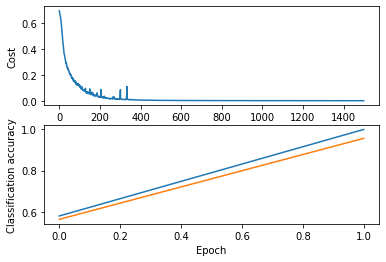

In [15]:
plt.subplot(2, 1, 1)
plt.plot(J_hist)
plt.xlabel('Iteration')
plt.ylabel('Cost')

plt.subplot(2, 1, 2)
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.tight_layout
plt.show()

<h3> Accuracy

In [16]:
y_pred = Net.predict(X_val)

confmat = cm(y_val,y_pred)

Accuracy = (confmat[0][0]+confmat[1][1])/len(y_val)
Sensitivity = (confmat[1][1])/(confmat[1][0] + confmat[1][1])
Specificity = (confmat[0][0])/(confmat[0][0] + confmat[0][1])
print(confmat)
print(f"Accuracy: {Accuracy*100}%\nSensitivity: {Sensitivity}\nSpecificity: {Specificity}")

[[204   0]
 [  0 226]]
Accuracy: 100.0%
Sensitivity: 1.0
Specificity: 1.0
